In [39]:
import laspy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from colorspacious import cspace_converter
import matplotlib as mpl

file_name = "220829GO15D"
#change file name according to flight being analysed

base_dir = "C:/Hobbies/programming/data/"
#file_path = base_dir + file_name + '/' + file_name + "_C_A.las"
#use file_path below for multiple flights on one date and adjust carefully
file_path = "C:/Hobbies/programming/data/220829GO15D/22GOempty/" + file_name + "_EMPTY_C_A.las"



In [40]:
def read_las(filename):
    reader = laspy.open(filename)
    pts = reader.read_points(reader.header.point_count)
    points = pd.DataFrame({
        'x': np.array(pts.x), 
        'y': np.array(pts.y), 
        'z': np.array(pts.z)
    })
    return points


data_table = read_las(file_path)
data_table.to_csv(file_name + "_C_A.csv")


In [41]:
import tqdm
#use the line below if loading a previously saved .csv to avoid index troubles
data_table = pd.read_csv(file_name + "_C_A.csv", index_col = 0)

#SCALE is the value by which all the x and y values will be divided for the decimation
SCALE = 0.05

#divides the x and y values of each point by SCALE and keeps the value rounded down to a full intiger.
#This gives neighbouring points the same grid_x and grid_y values.
def grid_ID(): 
    grid_xs = []
    grid_ys = []
    for x,y,_ in tqdm.tqdm(data_table.values):
        grid_x = x//SCALE
        grid_y = y//SCALE
        grid_xs.append(grid_x)
        grid_ys.append(grid_y)
        #grid_ID = grid_x, grid_y
        #gris_IDs.append(grid_ID)
    data_table['grid_x']= grid_xs
    data_table['grid_y']= grid_ys
    
grid_ID()


#Creates a new .csv to continue transformations on and reassigns the variable data_table
#data_table.to_csv(file_name + "_C_grid_ID.csv")
#data_table = pd.read_csv(file_name + "_C_grid_ID.csv", index_col = 0)

#makes tables for each row with matching grid_x and grid_y and from each table picks out the lowest z. 
#Creates a new table with all those lowest z values.
min_z = data_table.groupby(['grid_x', 'grid_y'])['z'].min().reset_index()

min_z
        
    




100%|██████████████████████████████████████████████████████████████████| 10491830/10491830 [00:14<00:00, 720939.07it/s]


grid_x       grid_y        z
0        6199781.0  103242918.0  533.251
1        6199787.0  103242942.0  533.274
2        6199793.0  103242925.0  533.244
3        6199796.0  103242906.0  533.206
4        6199799.0  103242949.0  533.274
...            ...          ...      ...
3981398  6203744.0  103245944.0  519.479
3981399  6203749.0  103245927.0  525.873
3981400  6203752.0  103245936.0  531.791
3981401  6203752.0  103245953.0  519.615
3981402  6203758.0  103245938.0  519.668

[3981403 rows x 3 columns]

In [42]:
min_z[["x","y"]] = min_z[['grid_x', 'grid_y']] * SCALE

min_z.to_csv(file_name + "_C_A_decimated_"+ str(SCALE) +".csv")    

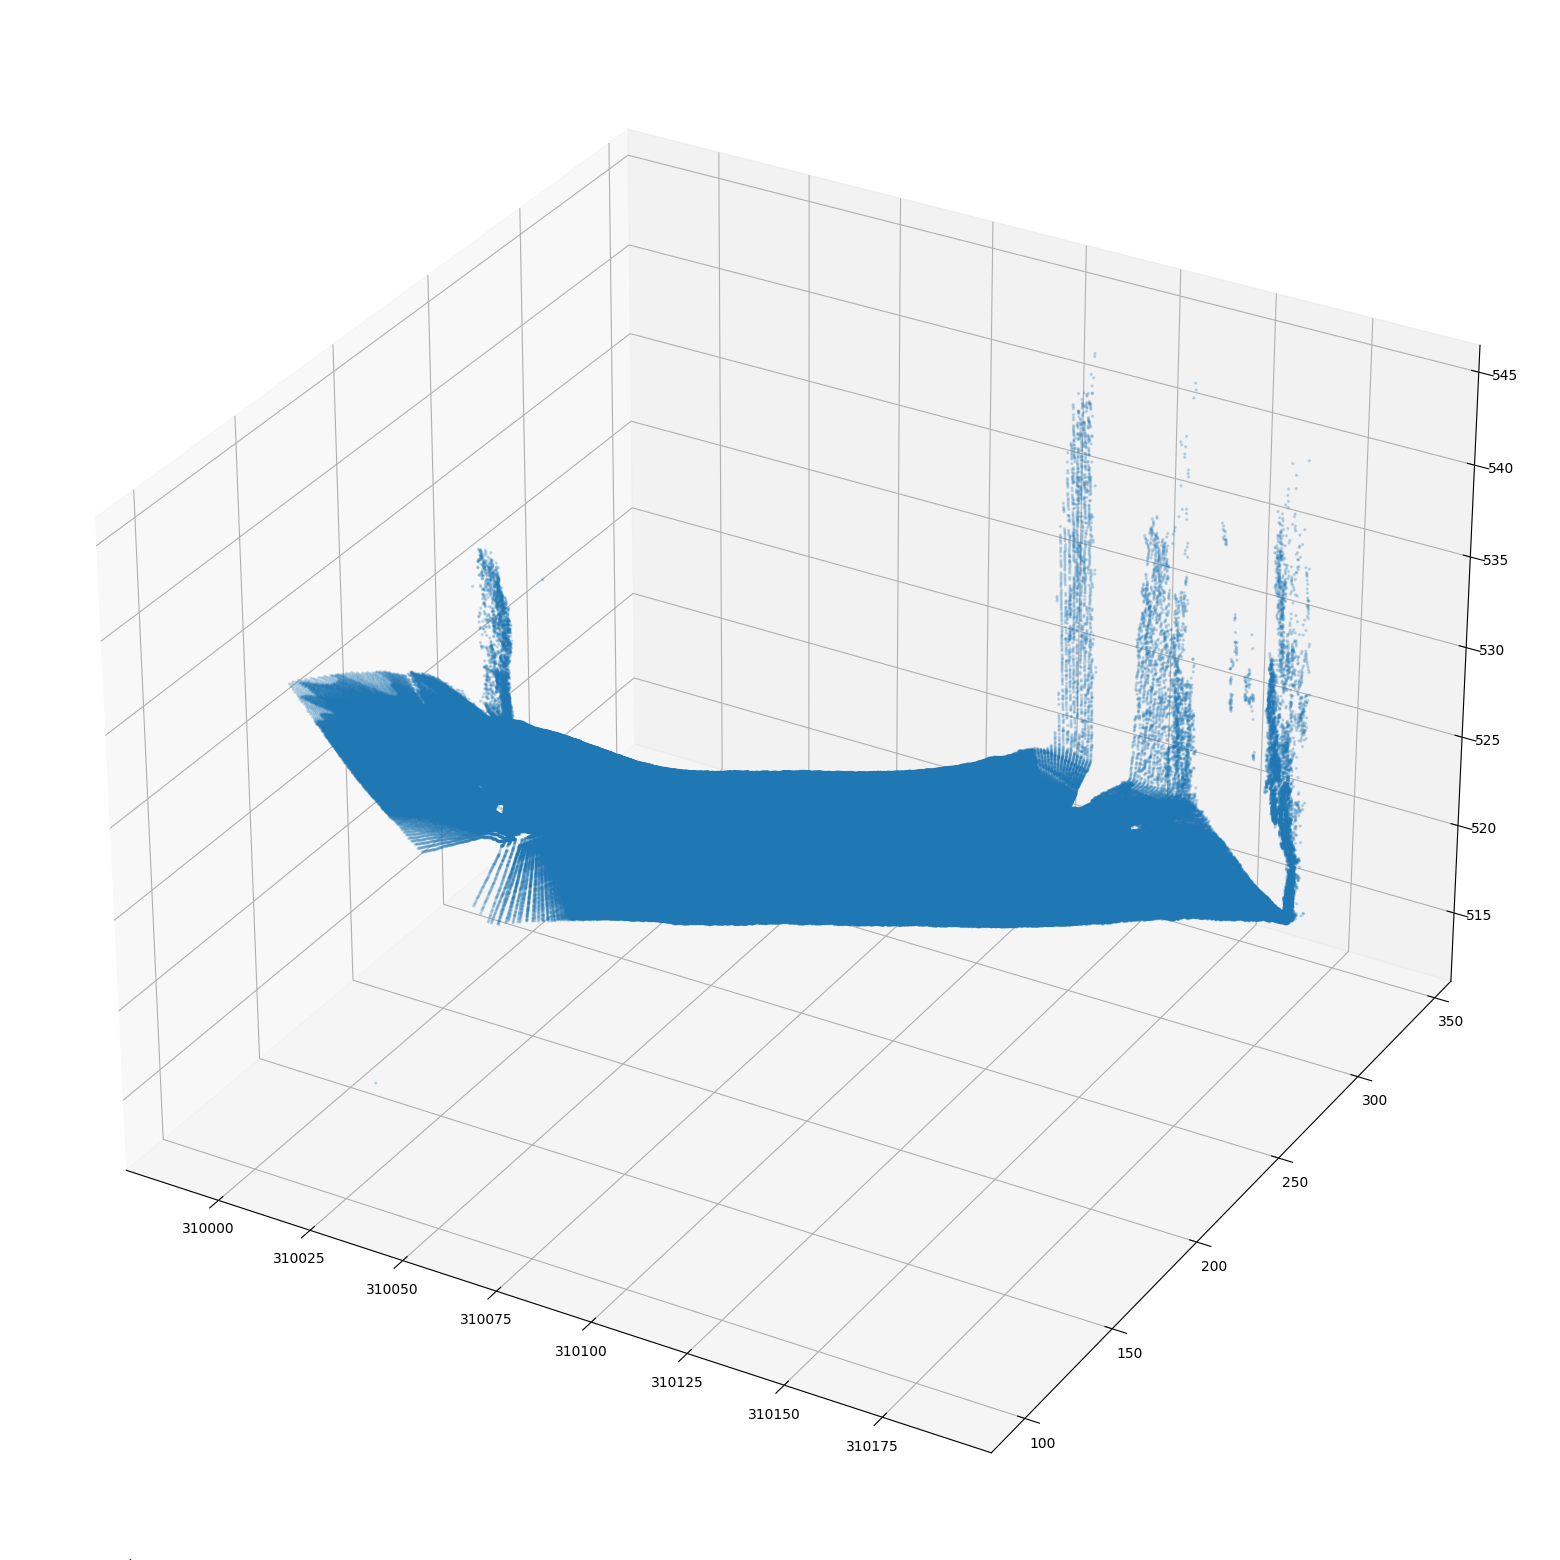

In [43]:


fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(projection='3d')
#ax.scatter(data_table.x, data_table.y, data_table.z, s = 1, alpha = 0.2)
ax.scatter(min_z.x, min_z.y, min_z.z, s = 2, alpha = 0.2)




In [56]:
datasets = dict(
    file_220829 = pd.read_csv("220829GO15D_EMPTY_C_A_decimated_0.05.csv"),
    file_220905 = pd.read_csv("220905GO15D_C_A_decimated_0.05.csv"),
    file_220912 = pd.read_csv("220912GO15D_C_A_decimated_0.05.csv"),
    file_221020 = pd.read_csv("221020GO60D_C_A_decimated_0.05.csv"),
    file_221101 = pd.read_csv("221101GO15D_C_A_decimated_0.05.csv"),
    file_221117 = pd.read_csv("221117GO15D_C_A_decimated_0.05.csv"),
    file_221128 = pd.read_csv("221128GO15D_C_A_decimated_0.05.csv"),
    file_230119 = pd.read_csv("230119GO15D_C_A_decimated_0.05.csv"))
      


In [60]:
def file_difference(data1, data2):
    zdif = data1.set_index(['grid_x', 'grid_y']).z - data2.set_index(['grid_x', 'grid_y']).z
    return zdif

def difference_file_name(tag1, tag2):
    return "height_differences_" + tag1 + "_" + tag2 + ".csv"

#compare all entries in datasets to entry tag1
tag1 = "file_220905"
for tag2, data2 in datasets.items():
    if tag2 == tag1:
        continue
    else:
        file_difference(file_220905, data2).to_csv(difference_file_name(tag1, tag2))
    

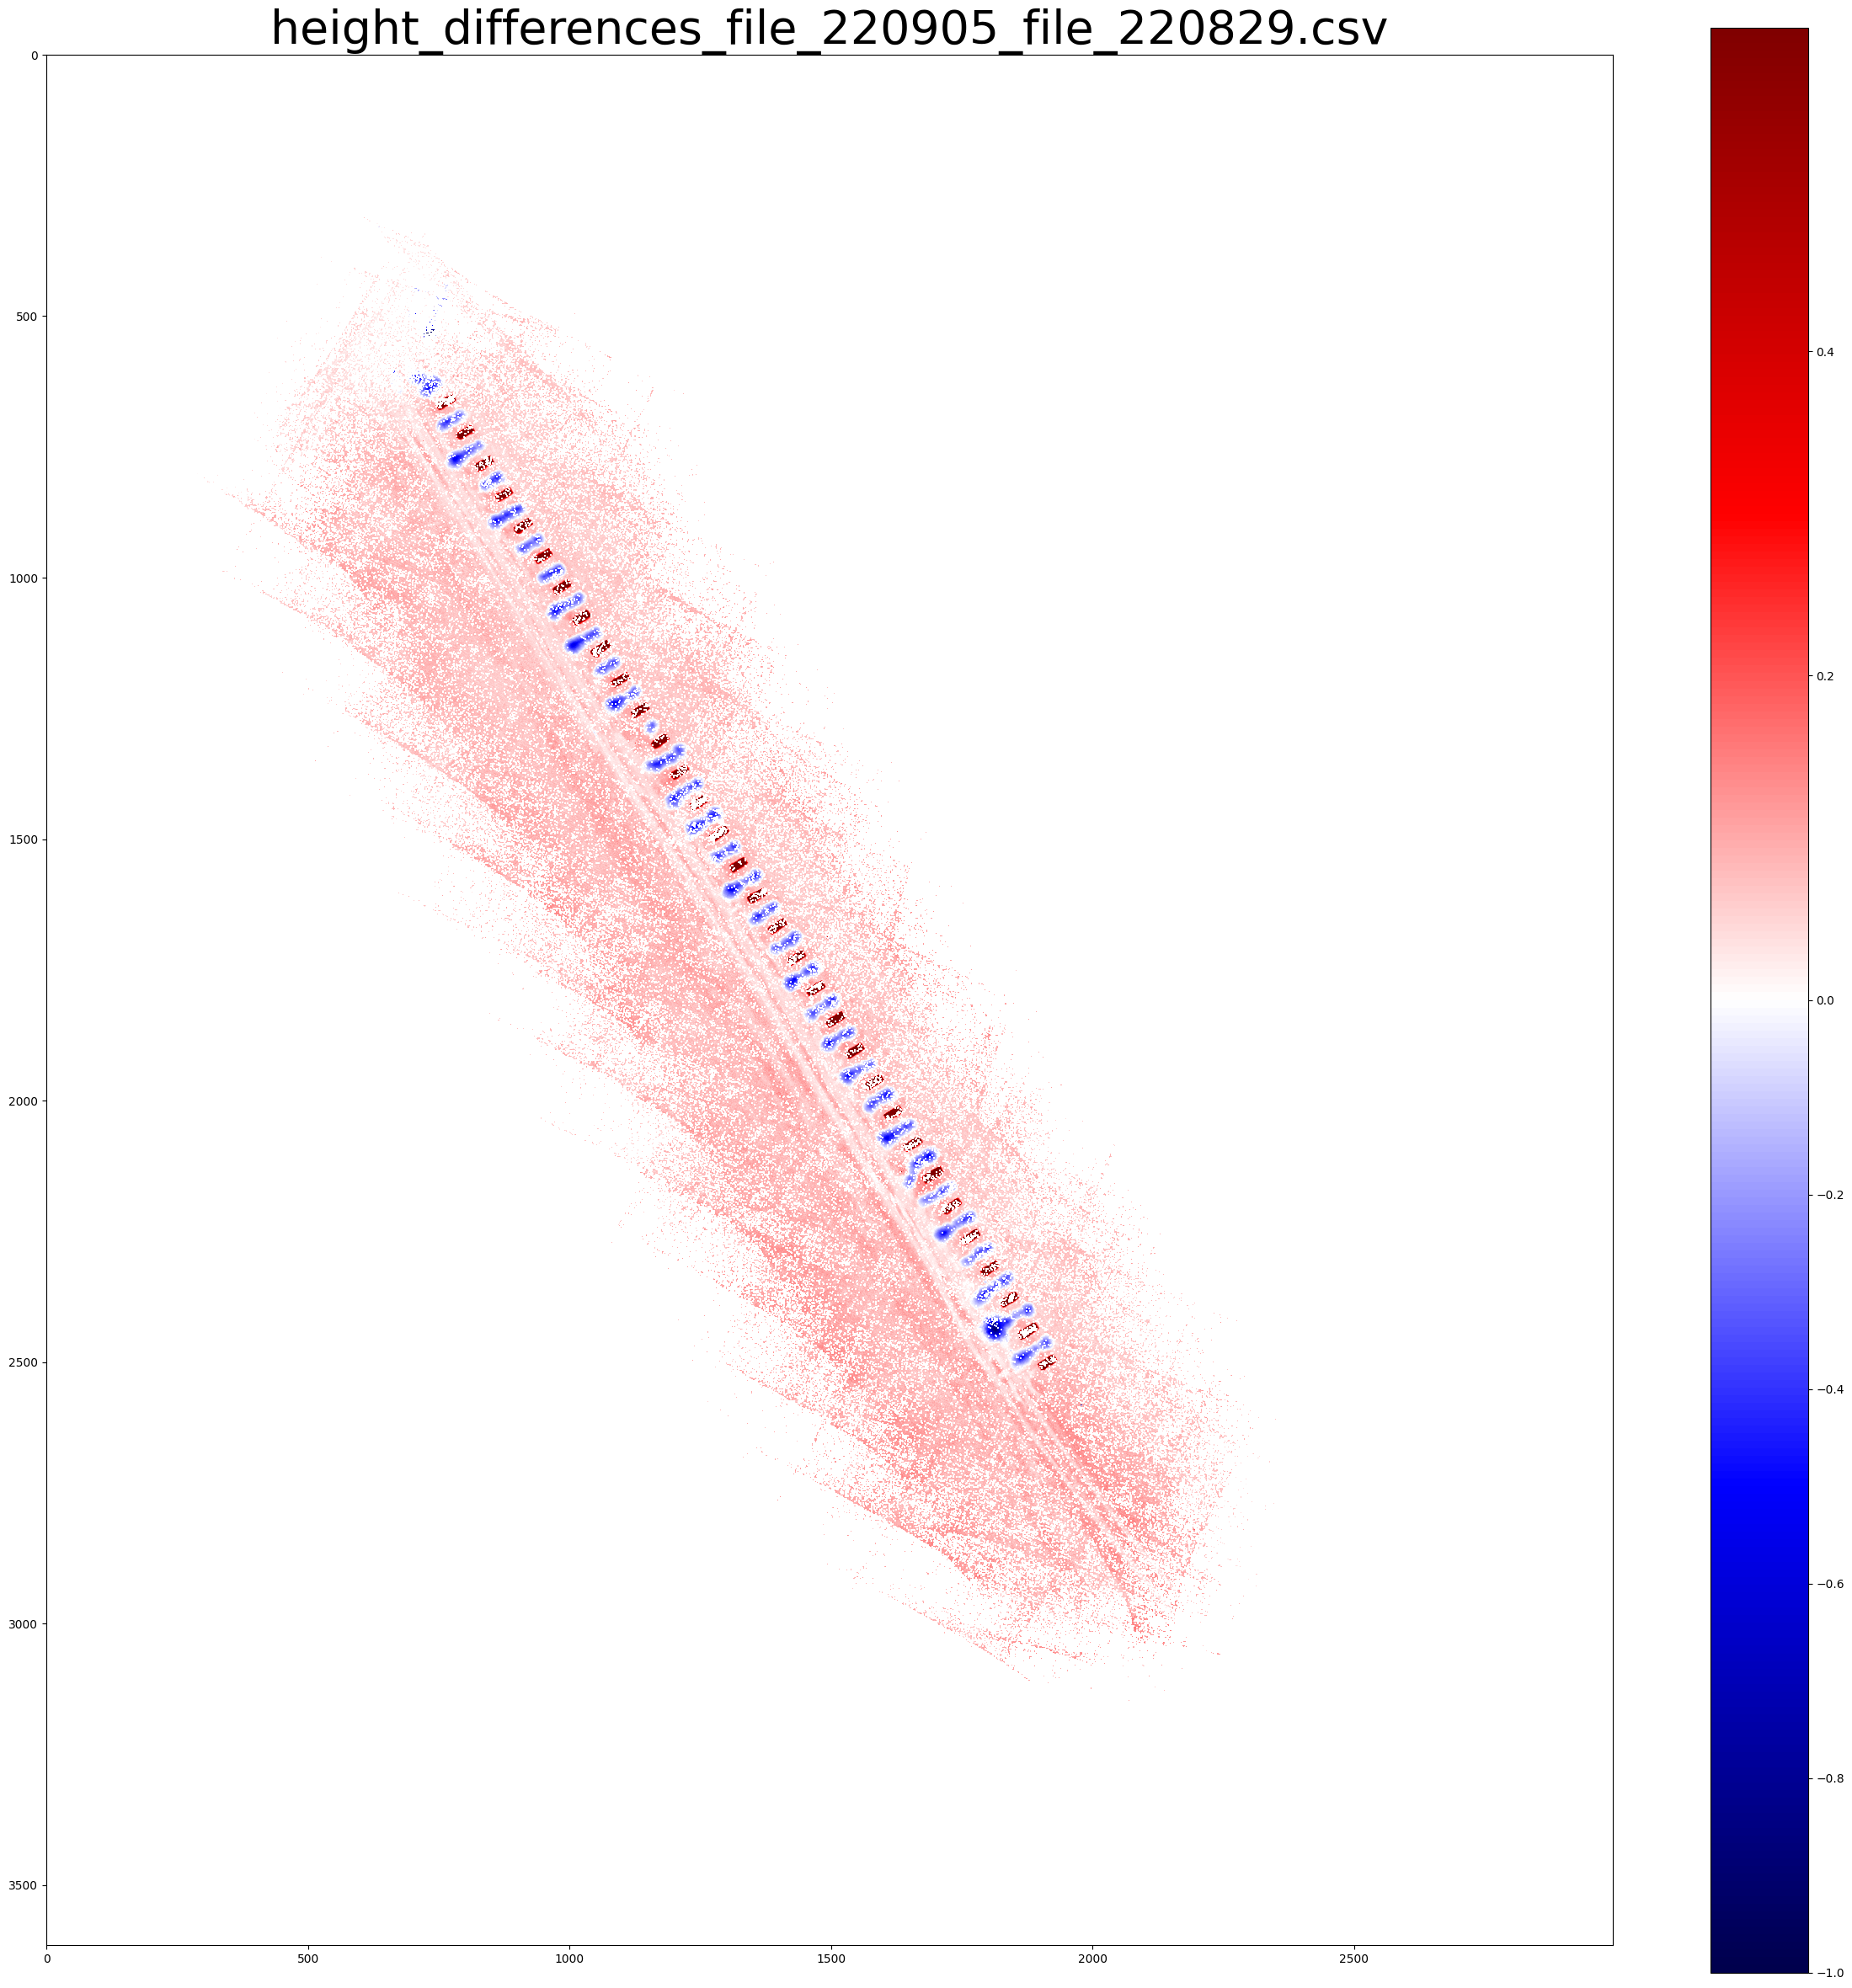

In [78]:
#z differences in about 1 week between 220905 and 220829 (decimated to 5cm squares)

file1 = "file_220905"
file2 = "file_220829"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

In [ ]:
#z differences in about 1 week between 220905 and 220912 (decimated to 5cm squares)

file1 = "file_220905"
file2 = "file_220912"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

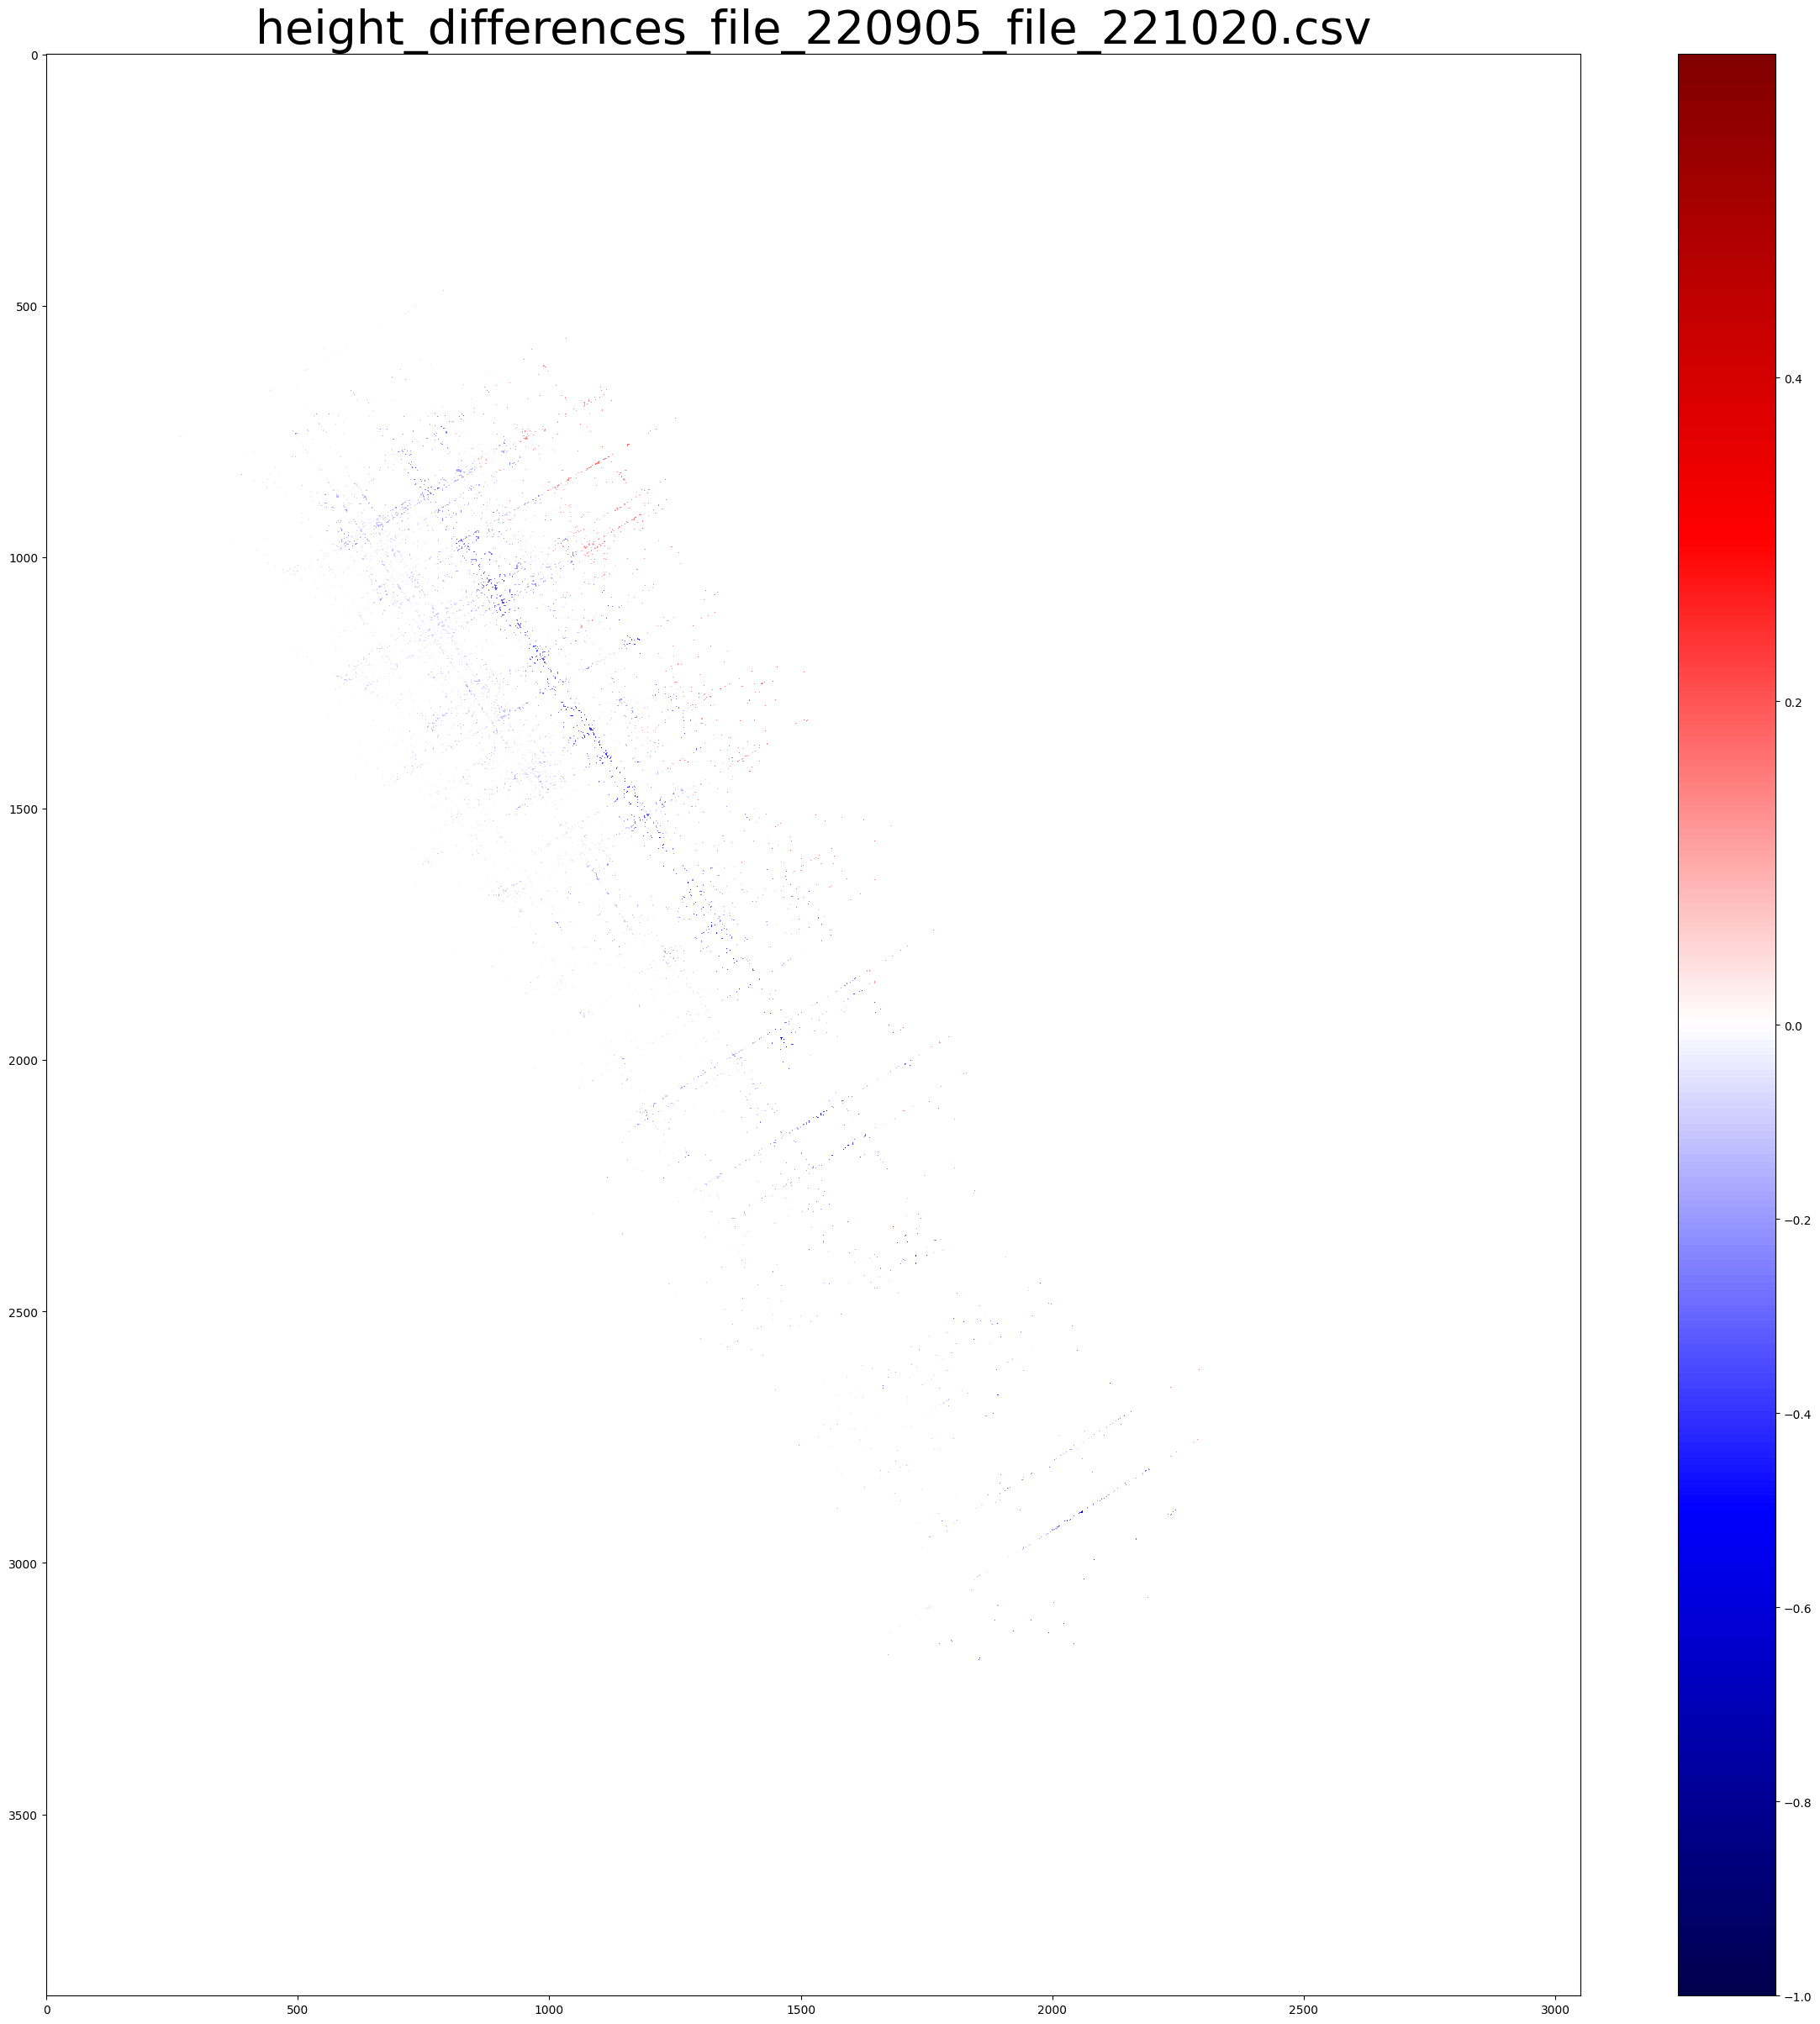

In [73]:
#z differences in 46 days between 220905 and 221020 (decimated to 5cm squares)
#very few datapoints because "file_221020" is a point cloud from 60m high instead of 15m.

file1 = "file_220905"
file2 = "file_221020"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

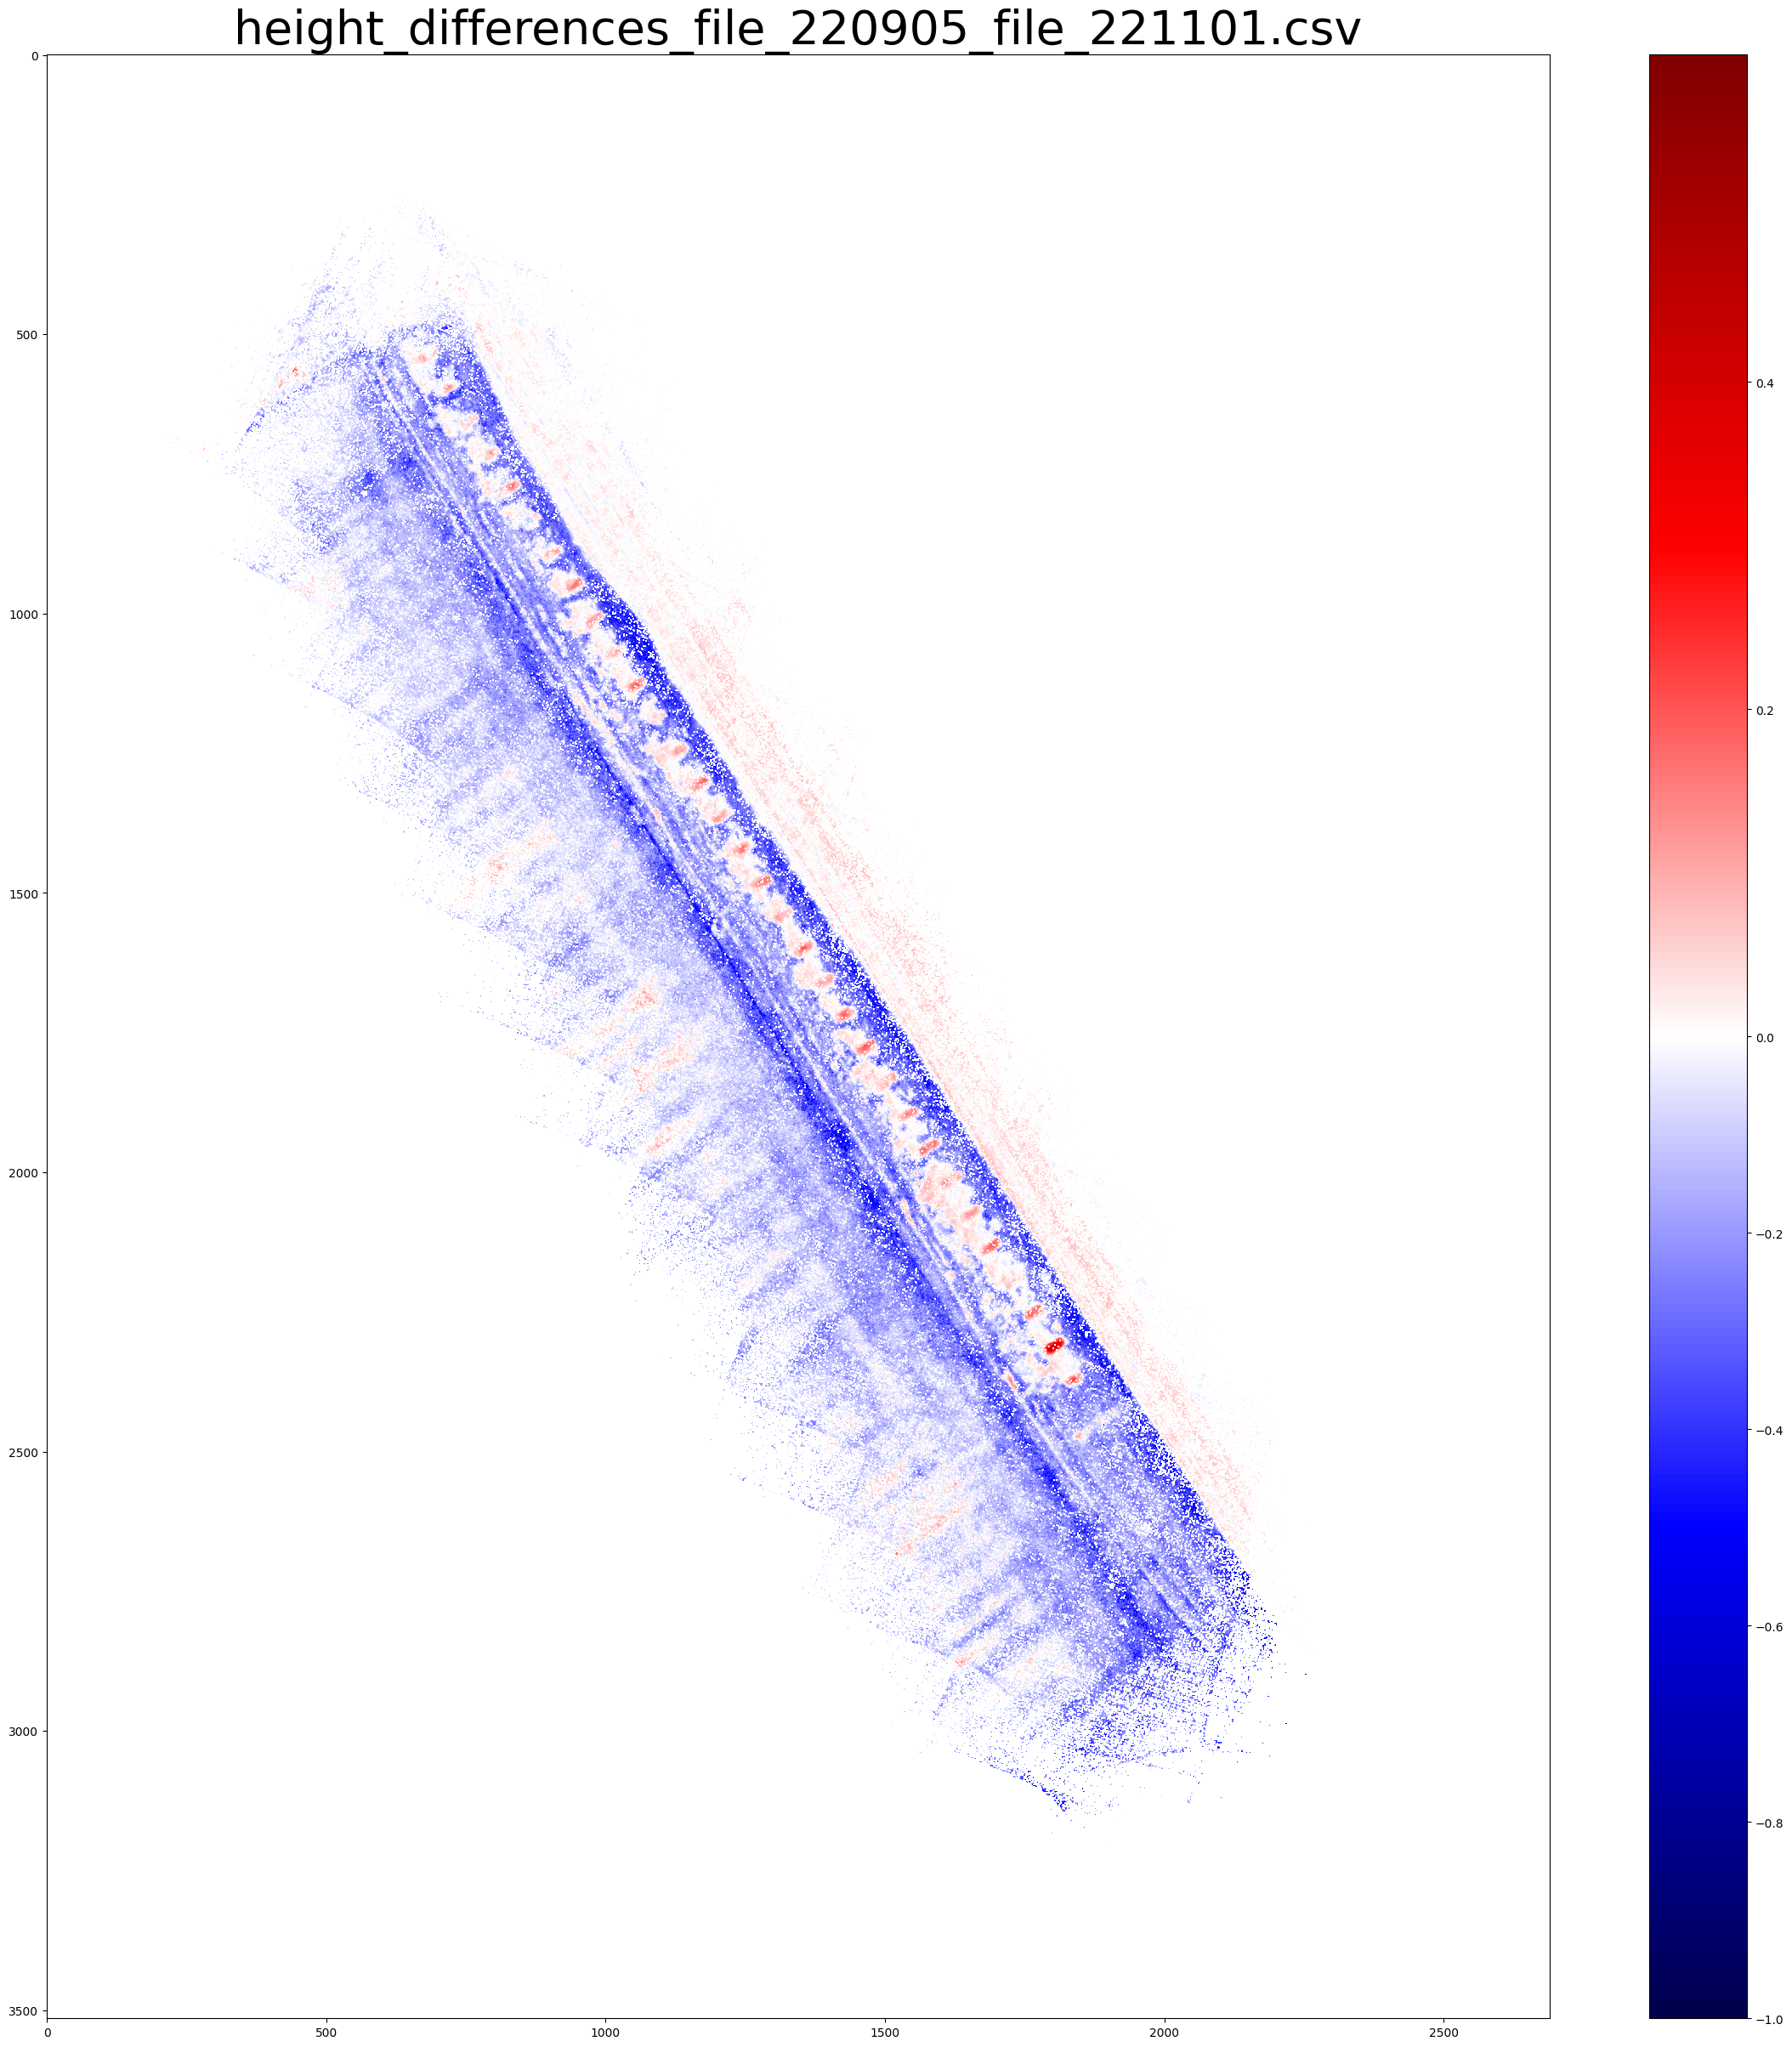

In [74]:
#z differences in 58 days between 220905 and 221101 (decimated to 5cm squares)

file1 = "file_220905"
file2 = "file_221101"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

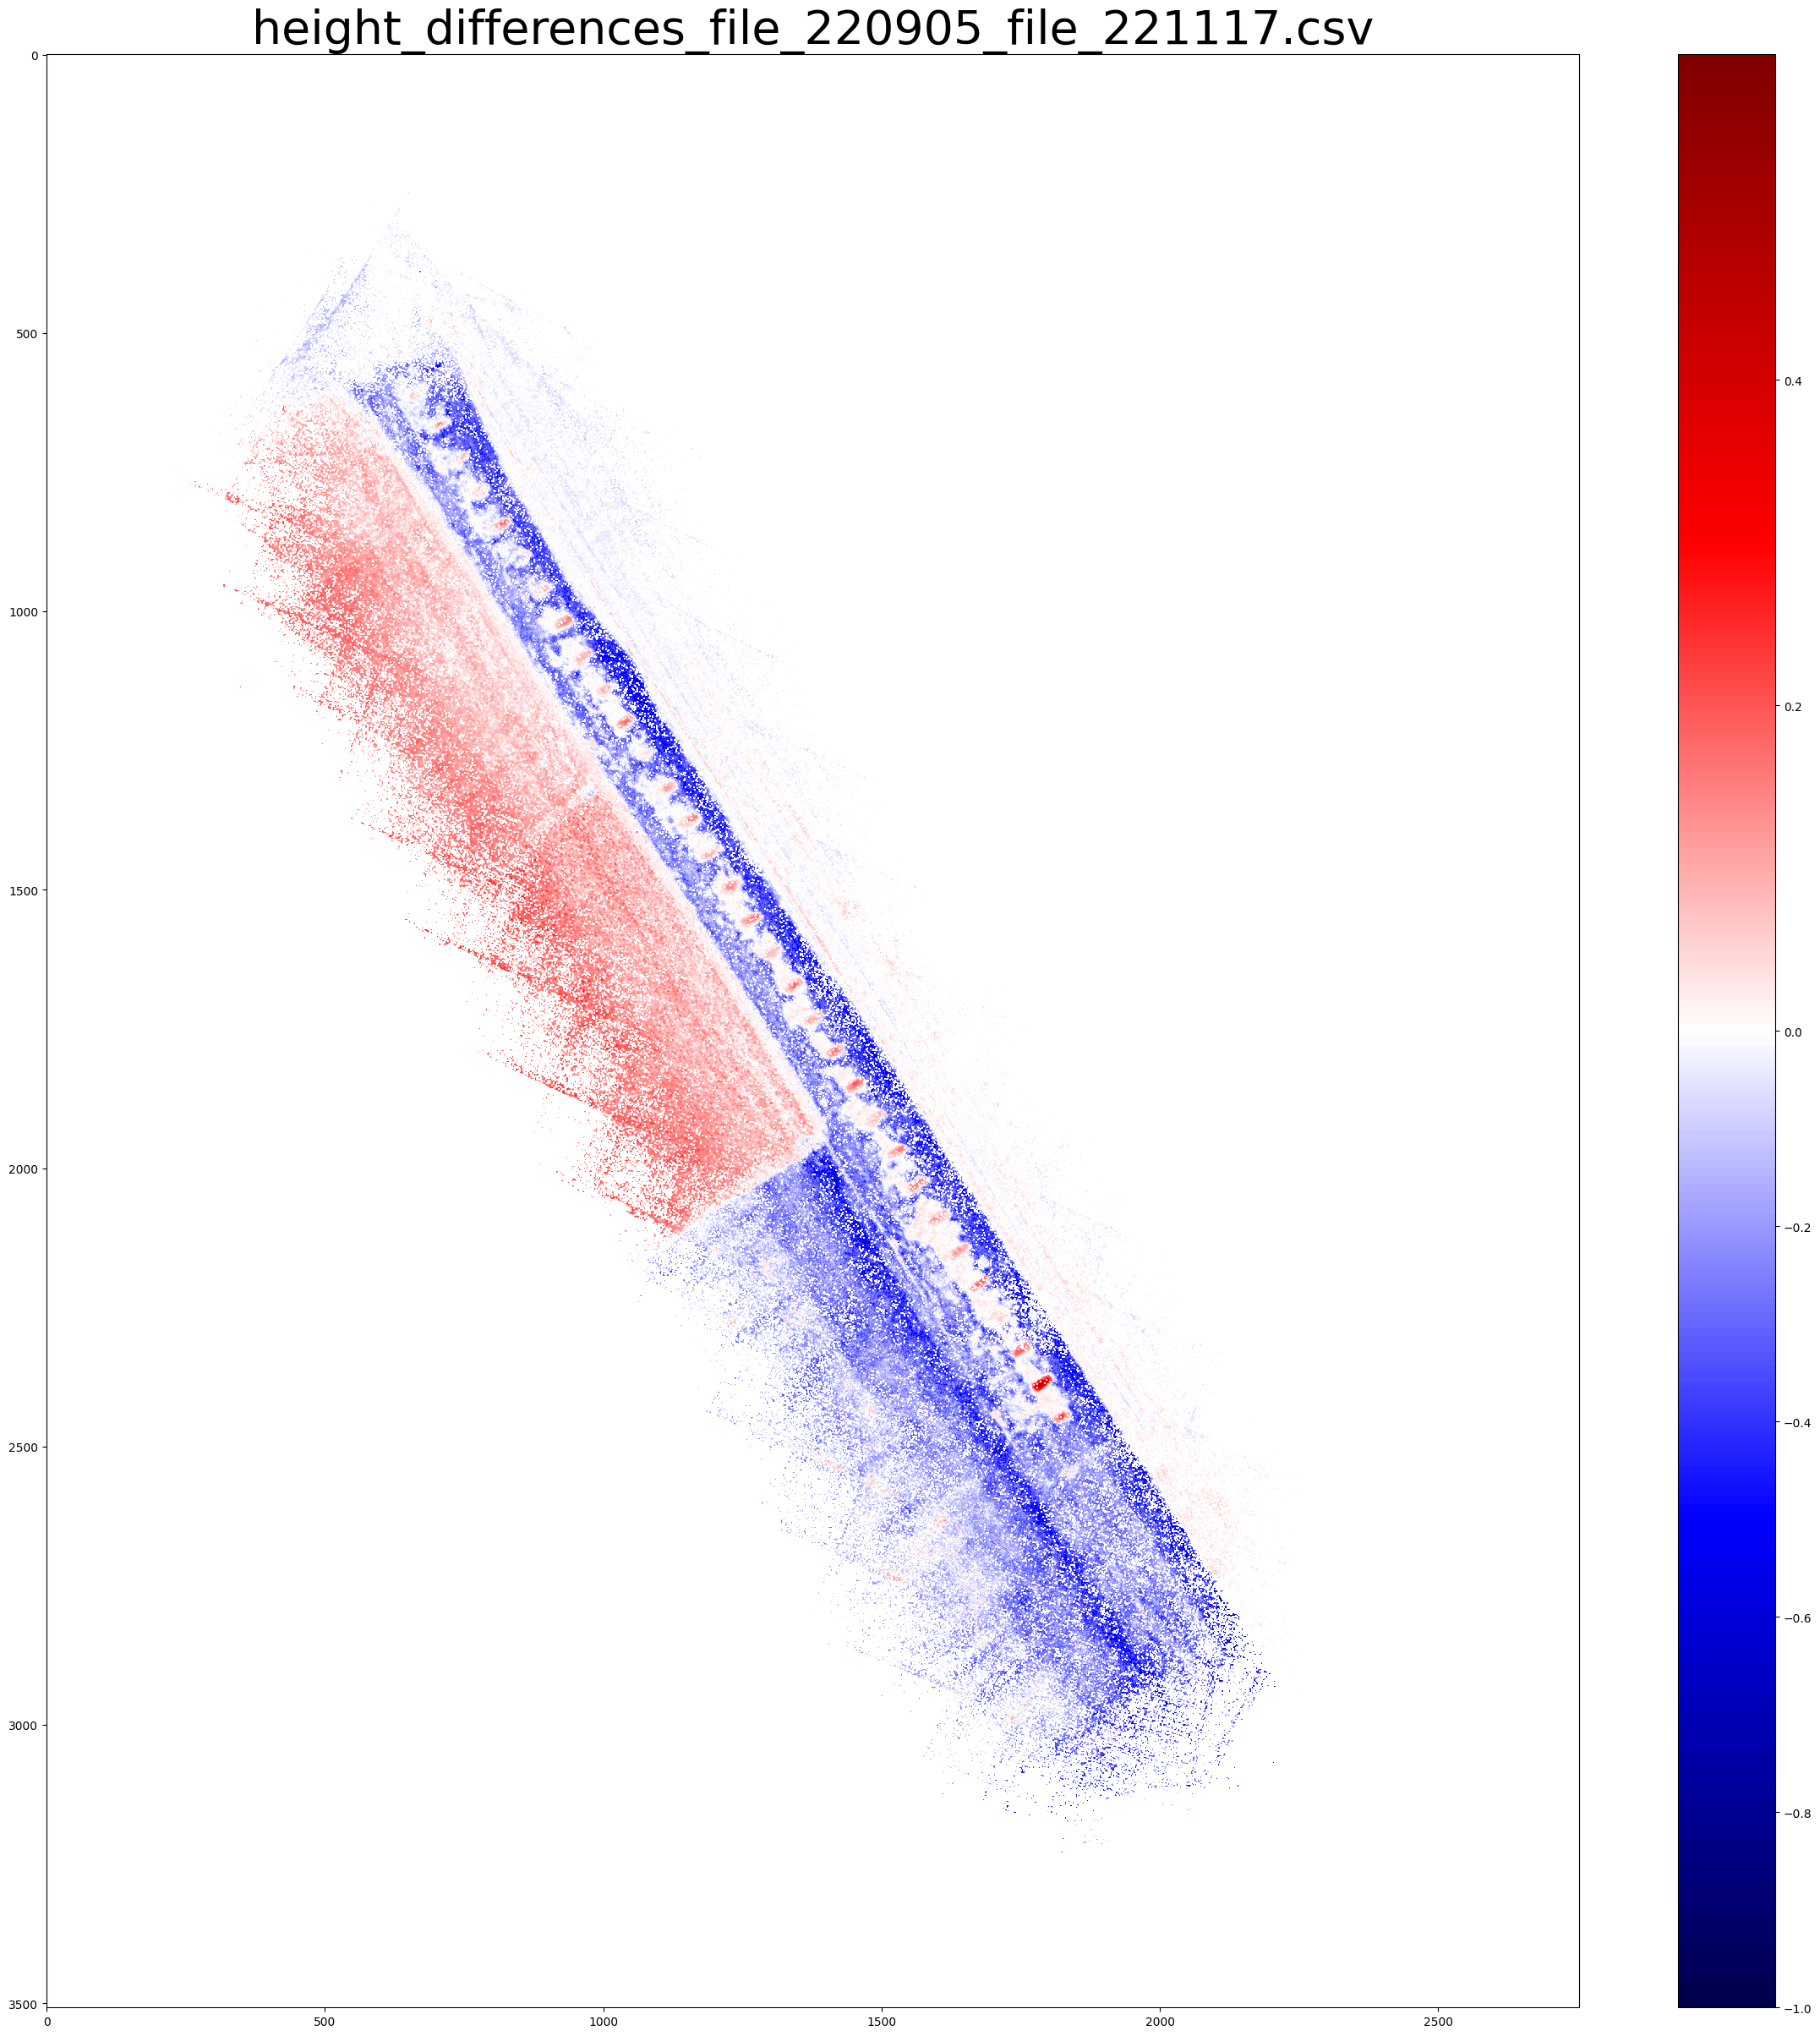

In [75]:
#z differences in 74 days between 220905 and 221117 (decimated to 5cm squares)

file1 = "file_220905"
file2 = "file_221117"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

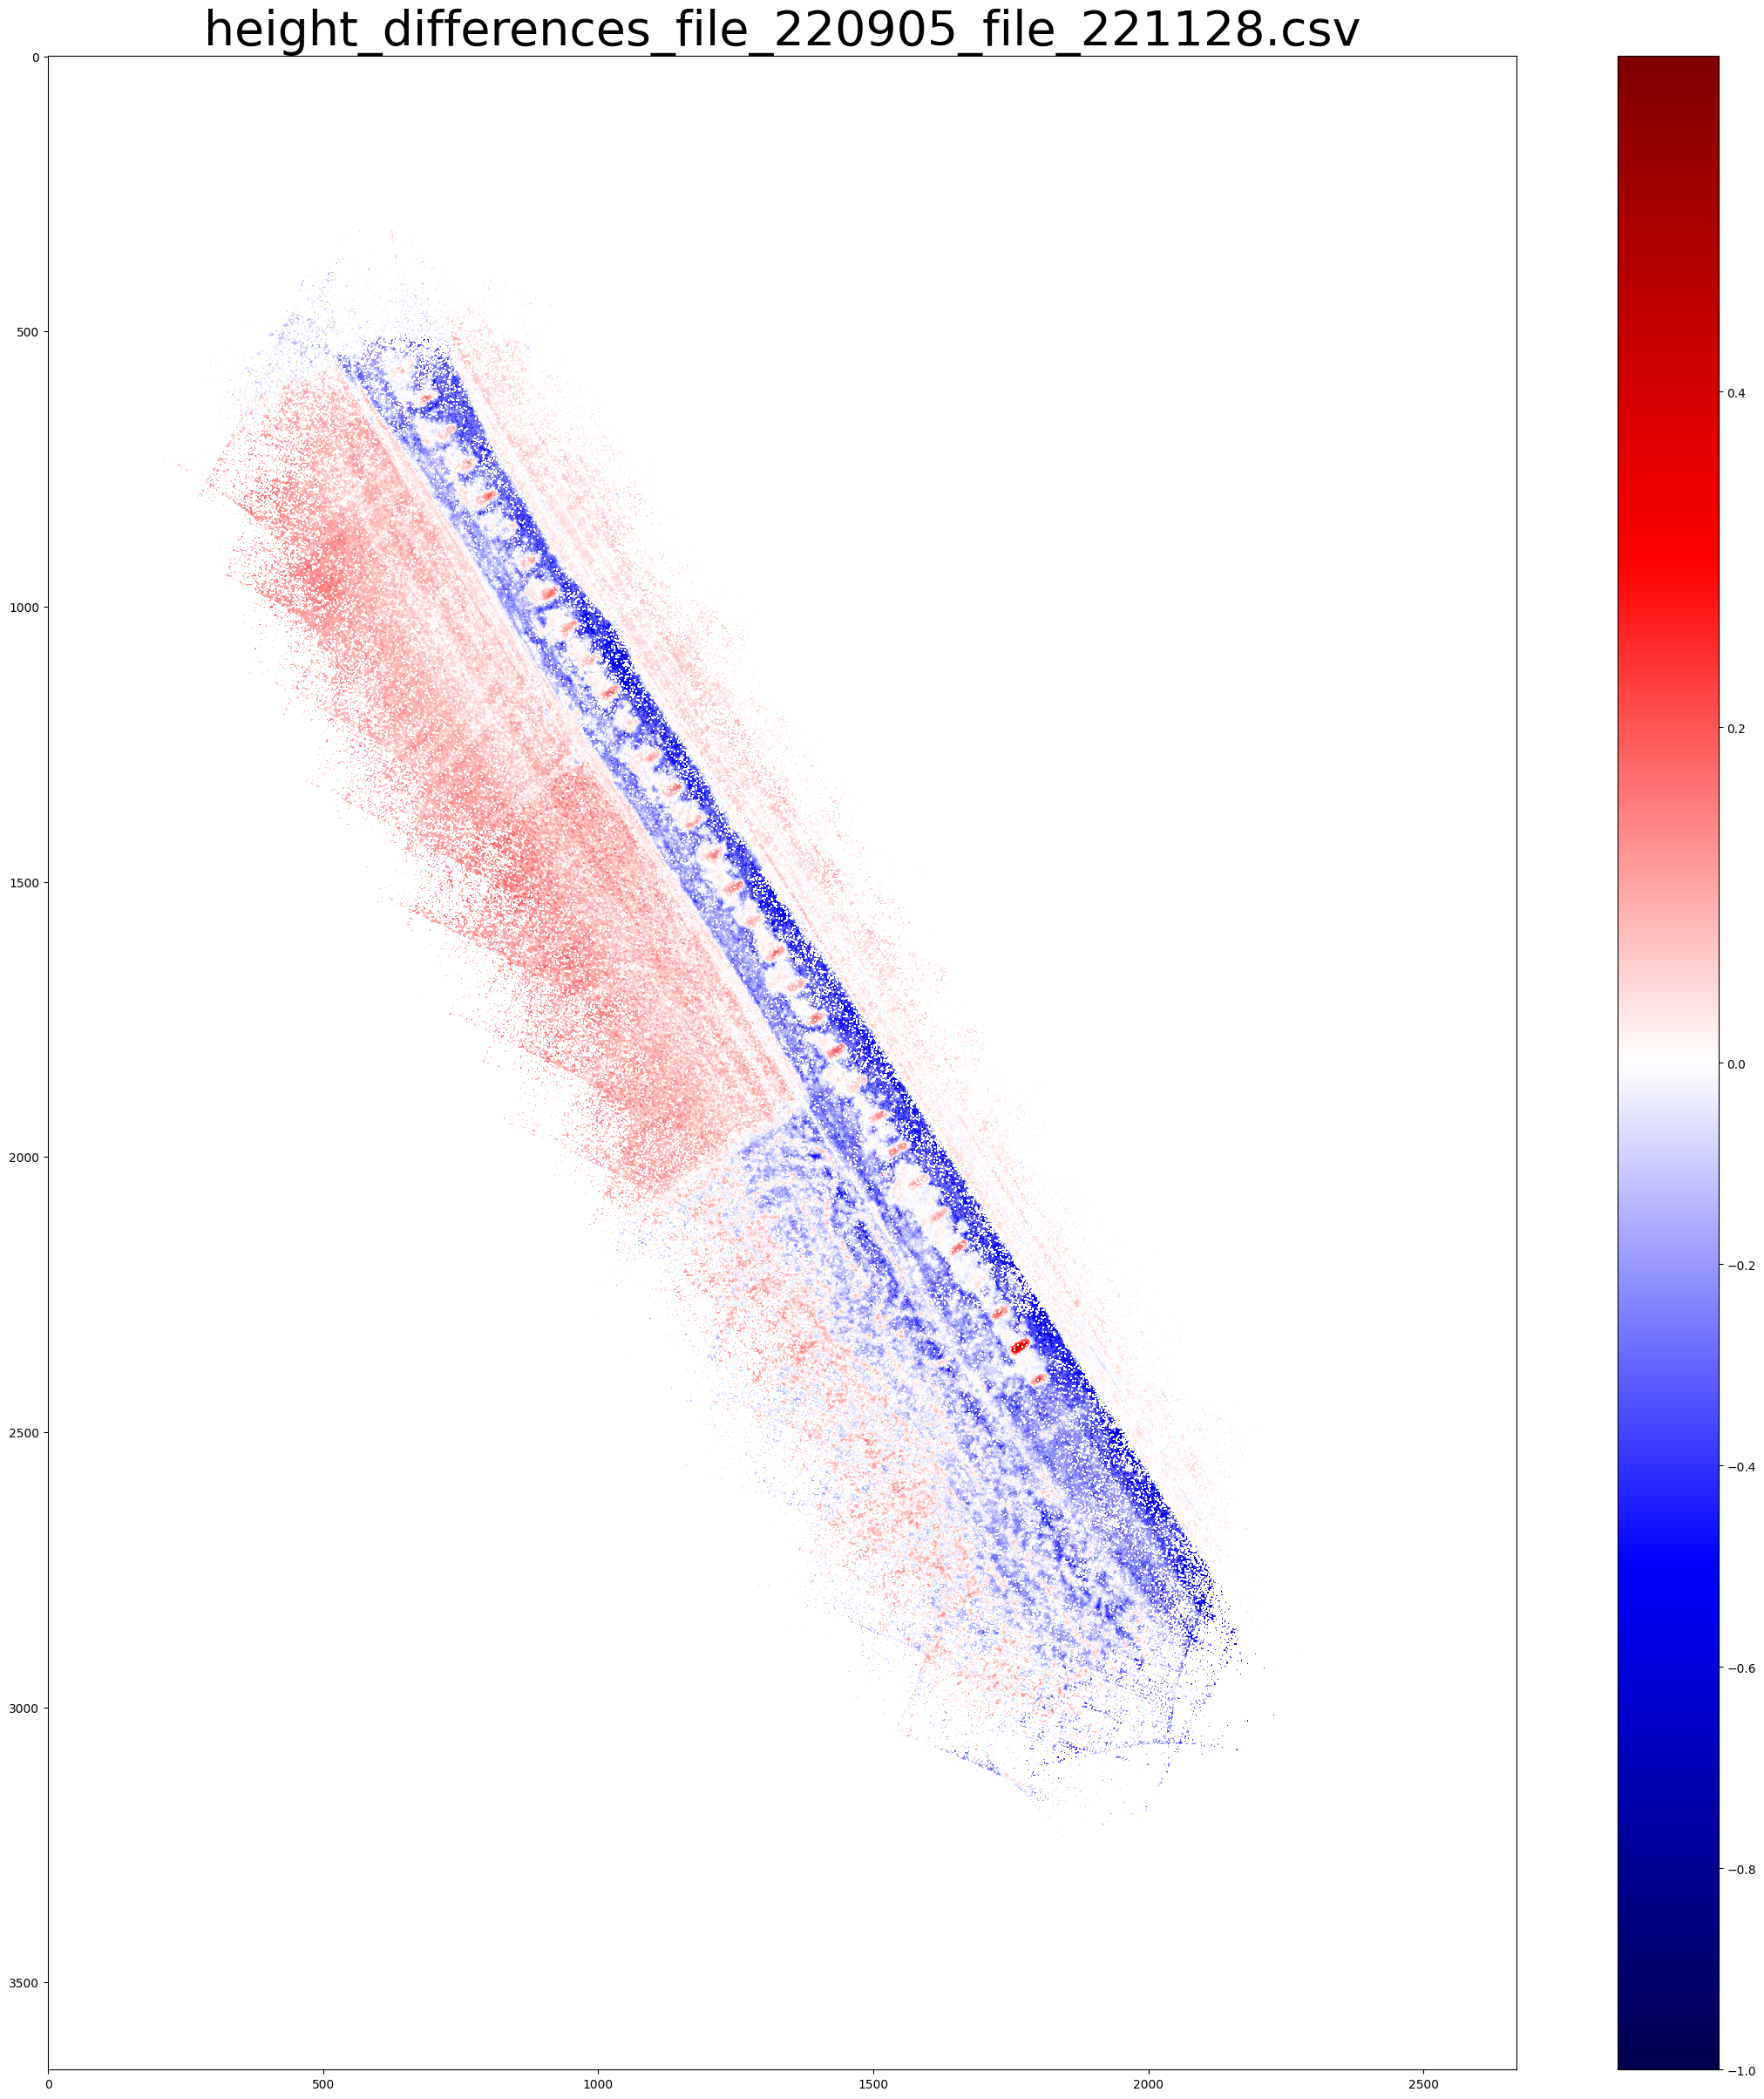

In [76]:
#z differences in 85 days between 220905 and 221128 (decimated to 5cm squares)


file1 = "file_220905"
file2 = "file_221128"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

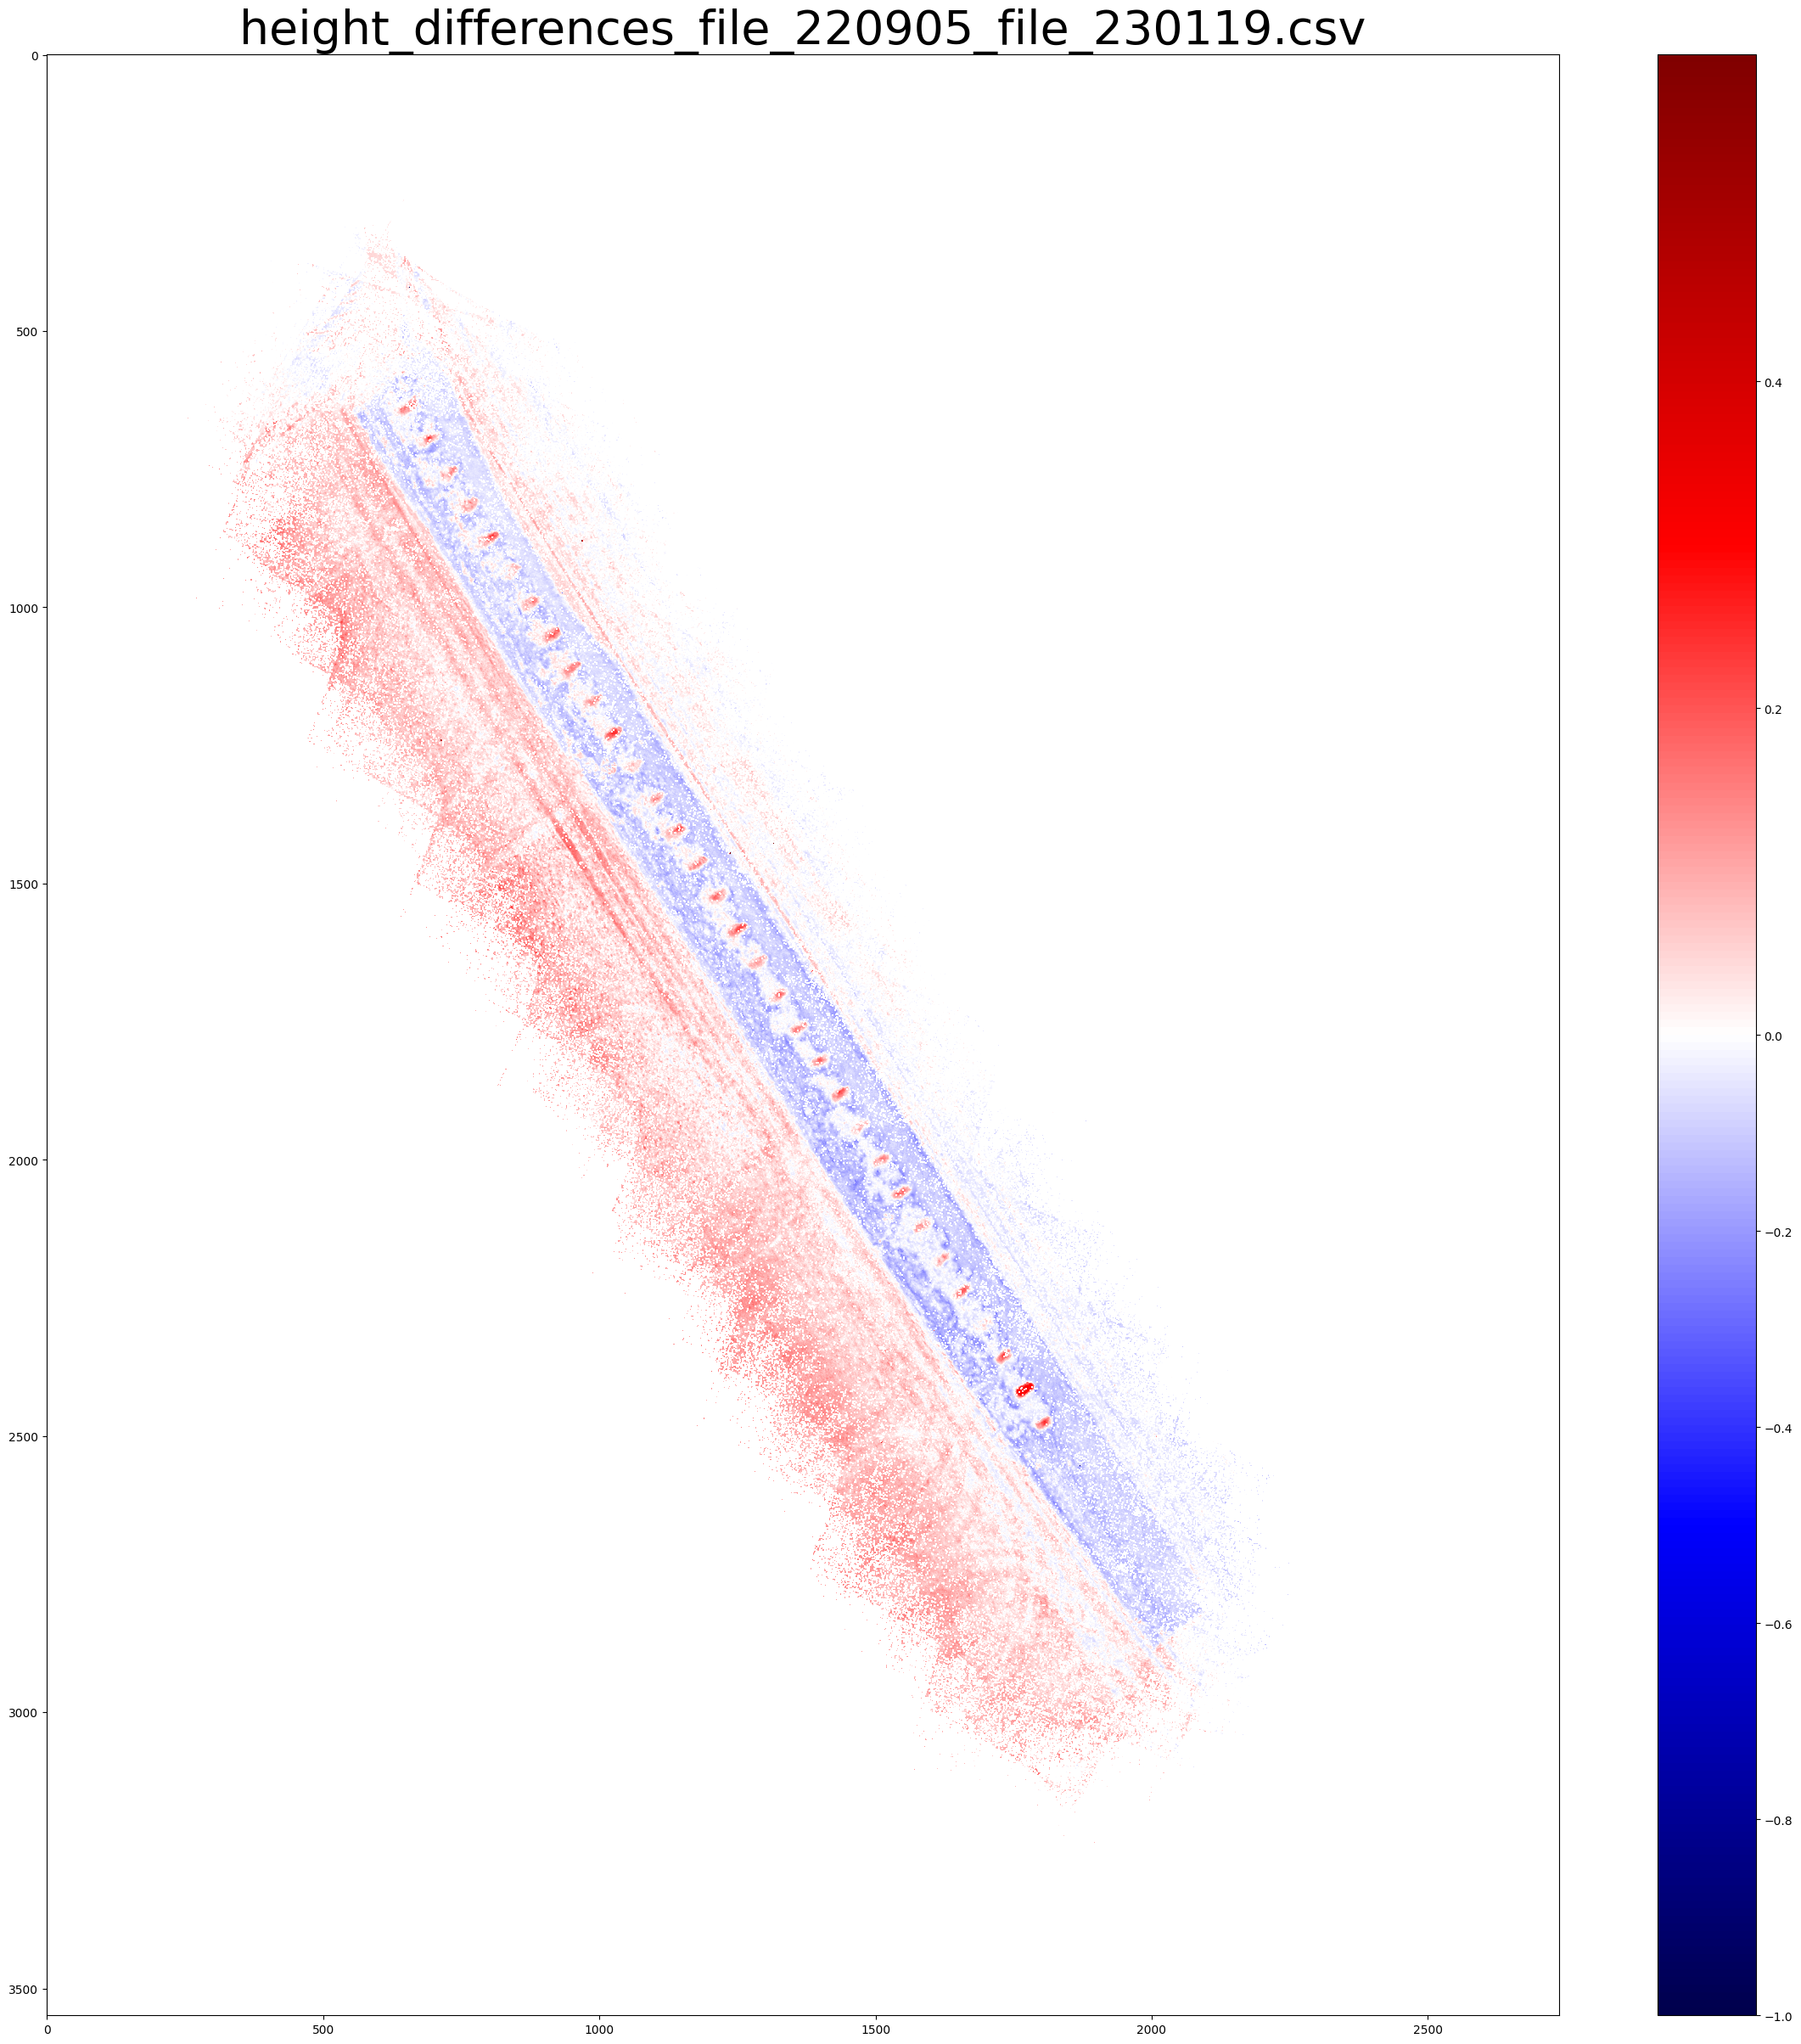

In [77]:
#z differences in 137 days between 220905 and 230119 (decimated to 5cm squares)

file1 = "file_220905"
file2 = "file_230119"

zdiff = pd.read_csv(difference_file_name(file1, file2))

grid = zdiff.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
plt.figure(figsize=(30, 30))
#grid.values[np.abs(grid.values) > 0.8] = np.nan
divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=0.6)
plt.title(difference_file_name(file1, file2), fontsize=40)
plt.imshow(grid.values, cmap = mpl.colormaps['seismic'], norm=divnorm)

plt.colorbar()

plt.savefig(difference_file_name(file1, file2).replace(".csv", ".png"))

In [2]:
def heatmap(grid_table):
    grid = grid_table.reset_index().pivot_table(columns='grid_x', index='grid_y', values='z')
    plt.imshow(grid.values)

In [60]:
np.isnan(file_220829).any()

Unnamed: 0    False
grid_x        False
grid_y        False
z             False
x             False
y             False
dtype: bool